In [77]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import pytorch_lightning as pl
import seaborn as sns
import torch
import umap
from lightly.data import LightlyDataset
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

from ssl_wafermap.models.knn import (
    BYOL,
    DCLW,
    DINO,
    MAE,
    MSN,
    PMSN,
    BarlowTwins,
    DINOViT,
    FastSiam,
    MoCo,
    SimCLR,
    SimMIM,
    SimSiam,
    SwaV,
    VICReg,
)
from ssl_wafermap.utilities.data import WaferMapDataset
from ssl_wafermap.utilities.plotting import matplotlibify, init_seaborn_style
from ssl_wafermap.utilities.transforms import get_inference_transforms

torch.set_float32_matmul_precision("high")
init_seaborn_style()

# Ignore pytorch lightning warning about dataloader workers
warnings.filterwarnings("ignore", message=".*does not have many workers.*")

Forgot to capitalize `"none"` to `"None"` in the preprocessing notebook. Instead of messing with it (since it involves randomly splitting the dataset), I just change this below.

In [2]:
# Mapping for sorting the failureType columns for better visualizations
mapping = {
    "Loc": 0,
    "None": 1,
    "Scratch": 2,
    "Edge-Ring": 3,
    "Center": 4,
    "Edge-Loc": 5,
    "Random": 6,
    "Donut": 7,
    "Near-full": 8,
}

data_dir = "../data/processed/WM811K/"
for file in os.listdir(data_dir):
    filepath = os.path.join(data_dir, file)
    df = pd.read_pickle(filepath)
    if "none" in df["failureType"].unique():
        # If the failureType column has lowercase "none", change it to "None"
        df["failureType"] = df["failureType"].str.replace("none", "None")
        # Now, convert the failureType column to a categorical column
        df["failureType"] = pd.Categorical(
            df["failureType"], categories=mapping.keys(), ordered=True
        )
        df.sort_values(by="failureType", inplace=True)
        display(df)
        # Save the updated dataframe if need be
        print(f"Saving updated dataframe for {file}")
        df.to_pickle(filepath, compression="xz")
    else:
        print(f"No additional preprocessing needed for {file}")

waferMap failureType   
21454  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc  \
9367   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128...         Loc   
9495   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
9712   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128...         Loc   
28376  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 128,...         Loc   
...                                                  ...         ...   
32777  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...   Near-full   
49454  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...   Near-full   
45960  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...   Near-full   
54998  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...   Near-full   
17549  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...   Near-full   

       failureCode  
21454            4  
9367             4  
9495             4  
9712             4  
28376            4  
...            ...  
32777            5  
49454            5  
45960            5  
54998            5  
17549            5  

[12450 rows x 3 columns]

Saving updated dataframe for test_data.pkl.xz


waferMap failureType   
578    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 255, 128,...         Loc  \
16518  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
30013  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128...         Loc   
30218  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
28903  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
...                                                  ...         ...   
28891  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   Near-full   
44277  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, ...   Near-full   
30837  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...   Near-full   
44222  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   Near-full   
16965  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...   Near-full   

       failureCode  
578              4  
16518            4  
30013            4  
30218            4  
28903            4  
...            ...  
28891            5  
44277            5  
30837            5  
44222            5  
16965            5  

[6225 rows x 3 columns]

Saving updated dataframe for train_10_split.pkl.xz


waferMap failureType   
28294  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128, 128,...         Loc  \
29018  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
19334  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
60077  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128, 2...         Loc   
28774  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
...                                                  ...         ...   
55806  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12...       Donut   
20461  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       Donut   
20495  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       Donut   
20561  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       Donut   
55750  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...   Near-full   

       failureCode  
28294            4  
29018            4  
19334            4  
60077            4  
28774            4  
...            ...  
55806            1  
20461            1  
20495            1  
20561            1  
55750            5  

[623 rows x 3 columns]

Saving updated dataframe for train_1_split.pkl.xz


waferMap failureType   
44059  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc  \
45     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
30363  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
30299  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
8954   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128...         Loc   
...                                                  ...         ...   
28280  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...   Near-full   
45170  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 255...   Near-full   
28563  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...   Near-full   
44344  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 255, 255,...   Near-full   
28303  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...   Near-full   

       failureCode  
44059            4  
45               4  
30363            4  
30299            4  
8954             4  
...            ...  
28280            5  
45170            5  
28563            5  
44344            5  
28303            5  

[12449 rows x 3 columns]

Saving updated dataframe for train_20_split.pkl.xz


waferMap failureType   
45259  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc  \
44476  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...         Loc   
9144   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128...         Loc   
29435  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 128,...         Loc   
57941  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128...         Loc   
...                                                  ...         ...   
33646  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...   Near-full   
44039  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   Near-full   
55745  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...   Near-full   
61801  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...   Near-full   
59525  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...   Near-full   

       failureCode  
45259            4  
44476            4  
9144             4  
29435            4  
57941            4  
...            ...  
33646            5  
44039            5  
55745            5  
61801            5  
59525            5  

[18051 rows x 3 columns]

Saving updated dataframe for train_29_split.pkl.xz


waferMap failureType   
57530  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc  \
36867  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...         Loc   
28774  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
13914  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12...         Loc   
57956  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
...                                                  ...         ...   
19362  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   Near-full   
814    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...   Near-full   
44916  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...   Near-full   
55504  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...   Near-full   
44344  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 255, 255,...   Near-full   

       failureCode  
57530            4  
36867            4  
28774            4  
13914            4  
57956            4  
...            ...  
19362            5  
814              5  
44916            5  
55504            5  
44344            5  

[37348 rows x 3 columns]

Saving updated dataframe for train_data.pkl.xz


waferMap failureType   
21324  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc  \
30039  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
45248  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
30370  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
27540  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
...                                                  ...         ...   
28880  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   Near-full   
29003  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   Near-full   
18124  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...   Near-full   
55768  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...   Near-full   
44926  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...   Near-full   

       failureCode  
21324            4  
30039            4  
45248            4  
30370            4  
27540            4  
...            ...  
28880            5  
29003            5  
18124            5  
55768            5  
44926            5  

[49798 rows x 3 columns]

Saving updated dataframe for train_val_data.pkl.xz


waferMap failureType   
9442   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128...         Loc  \
29672  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 128...         Loc   
31129  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...         Loc   
22190  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 128, 255, 12...         Loc   
9394   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128...         Loc   
...                                                  ...         ...   
55769  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...   Near-full   
44922  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...   Near-full   
28456  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...   Near-full   
56110  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, ...   Near-full   
44938  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...   Near-full   

       failureCode  
9442             4  
29672            4  
31129            4  
22190            4  
9394             4  
...            ...  
55769            5  
44922            5  
28456            5  
56110            5  
44938            5  

[12450 rows x 3 columns]

Saving updated dataframe for val_data.pkl.xz


In [20]:
for file in os.listdir(data_dir):
    filepath = os.path.join(data_dir, file)
    df_temp = pd.read_pickle(filepath)
    print(df_temp.isna().sum())

waferMap       0
failureType    0
failureCode    0
dtype: int64
waferMap       0
failureType    0
failureCode    0
dtype: int64
waferMap       0
failureType    0
failureCode    0
dtype: int64
waferMap       0
failureType    0
failureCode    0
dtype: int64
waferMap       0
failureType    0
failureCode    0
dtype: int64
waferMap       0
failureType    0
failureCode    0
dtype: int64
waferMap       0
failureType    0
failureCode    0
dtype: int64
waferMap       0
failureType    0
failureCode    0
dtype: int64


In [7]:
df_full = pd.read_pickle("../data/processed/WM811K/train_data.pkl.xz")
df_subset = pd.read_pickle("../data/processed/WM811K/train_20_split.pkl.xz")

full_dataset = LightlyDataset.from_torch_dataset(
    WaferMapDataset(df_full.waferMap, df_full.failureCode),
    transform=get_inference_transforms(),
)
subset_dataset = LightlyDataset.from_torch_dataset(
    WaferMapDataset(df_subset.waferMap, df_subset.failureCode),
    transform=get_inference_transforms(),
)

full_loader = DataLoader(full_dataset, batch_size=1024, shuffle=False)
subset_loader = DataLoader(subset_dataset, batch_size=1024, shuffle=False)

In [169]:
ckpt_dir = "../models/new_knn/"
ckpt_file_end = "checkpoints/epoch=149-step=87450.ckpt"

for folder in os.listdir(ckpt_dir):
    # Full path, i.e. ../models/new_knn/MAE/checkpoints/epoch=149-step=87450.ckpt
    ckpt_path =os.path.join(ckpt_dir, folder, ckpt_file_end)

    # Get model name, i.e. MAE
    model_name = ckpt_path.split("new_knn/")[-1].split("\\")[0]
    print(model_name)
    if model_name == "MAE2":
        model_name = "MAE"
    
    # Get the model class using the model_name
    ModelClass = getattr(sys.modules[__name__], model_name)

    # Instantiate a model of this class and load ckpt weights
    model = ModelClass().load_from_checkpoint(ckpt_path)

    trainer = pl.Trainer(accelerator="gpu", logger=False, inference_mode=True, precision="16-mixed")

    # For each dataloader,
    for loader, df in zip([subset_loader, full_loader], [df_subset, df_full]):
        # Perform inference
        preds = trainer.predict(model, loader)
        preds = torch.cat(preds).cpu().numpy()

        scaler = StandardScaler()
        preds = scaler.fit_transform(preds)

        # Create a UMAP embedding
        reducer = umap.UMAP(random_state=0)
        embeddings = reducer.fit_transform(preds)
        umap_df = pd.DataFrame(embeddings, columns=["x", "y"])
        umap_df["failureType"] = df.failureType.values

        # Create a DensMAP embedding
        reducer = umap.UMAP(random_state=0, densmap=True, dens_lambda=1)
        dense_embeddings = reducer.fit_transform(preds)
        dense_umap_df = pd.DataFrame(dense_embeddings, columns=["x", "y"])
        dense_umap_df["failureType"] = df.failureType.values

        # Plot the embeddings
        fig = px.scatter(
            umap_df,
            x="x",
            y="y",
            color="failureType",
            width=800,
            height=600,
            title=f"{model_name} UMAP Embedding",
        )
        fig.show()

        fig = px.scatter(
            dense_umap_df,
            x="x",
            y="y",
            color="failureType",
            width=800,
            height=600,
            title=f"{model_name} DensMAP Embedding",
        )
        fig.show()

        break

    break

BarlowTwins


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

C:\Users\khanm\AppData\Local\Temp\ipykernel_25200\2868378420.py:4: UserWarning:

The palette list has more values (10) than needed (9), which may not be intended.



<AxesSubplot:xlabel='x', ylabel='y'>

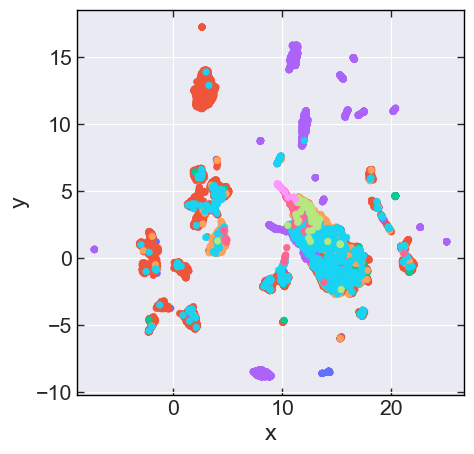

In [63]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=umap_df, x="x", y="y", hue="failureType", ax=ax, legend=False, palette=px.colors.qualitative.Plotly, edgecolor=None)
# sns.move_legend(ax, bbox_to_anchor=(1, 1), loc="upper left")

In [172]:
# Plot the embeddings
fig = px.scatter(
    umap_df,
    x="x",
    y="y",
    color="failureType",
    width=800,
    height=600,
    template="none",
    color_discrete_sequence=px.colors.qualitative.Plotly,
)
fig.update_traces(marker={'size': 4.5})
fig.update_xaxes(
    showgrid=False,
    showticklabels=False,
    ticks="",
    zeroline=False,
    showline=True,
    linewidth=2.4,
    linecolor="black",
    mirror="allticks",
)
fig.update_yaxes(
    showgrid=False,
    showticklabels=False,
    ticks="",
    zeroline=False,
    showline=True,
    linewidth=2.4,
    linecolor="black",
    mirror="allticks",
)
font_dict = dict(family="Arial", size=20, color="black")

fig.update_layout(
    font=font_dict,
    legend_title="Failure Type",
    margin=dict(r=40, t=20, b=10),
    legend={"itemsizing": "constant"},
    xaxis_title="",
    yaxis_title="",
    # showlegend=False
)

# fig, scale = matplotlibify(fig, font_size=20, width_inches=5, height_inches=3.5, dpi=142)
fig.show()

fig1 = px.scatter(
    dense_umap_df,
    x="x",
    y="y",
    color="failureType",
    width=800,
    height=600,
    title=f"{model_name} DensMAP Embedding",
)
fig1.update_layout(showlegend=False)

fig1.show()

In [181]:
from plotly.subplots import make_subplots

fig0 = px.scatter(
    umap_df,
    x="x",
    y="y",
    color="failureType",
    width=800,
    height=600,
    title=f"{model_name} UMAP Embedding",
)
fig0.show()

fig1 = px.scatter(
    dense_umap_df,
    x="x",
    y="y",
    color="failureType",
    width=800,
    height=600,
    title=f"{model_name} DensMAP Embedding",
)
fig1.show()


# Plot fig and fig1 side by side
fig2 = make_subplots(
    rows=1, cols=2,
    column_widths=[0.5, 0.5],
    specs=[[{"type": "xy"}, {"type": "xy"}]],
    subplot_titles=("UMAP", "DensMAP"),
)
for trace in fig0.data:
    fig2.add_trace(trace, row=1, col=1)

for trace in fig1.data:
    fig2.add_trace(trace, row=1, col=2)

fig2.update_traces(legendgroup="failureType")
fig2.update_traces(showlegend=True)
# fig2.update_traces(showlegend=[True, False])

fig2.update_layout(
    width=1500,
    height=600,
    font=font_dict,
    legend_title="Failure Type",
    margin=dict(r=40, t=20, b=10),
    legend={"itemsizing": "constant"},
    xaxis_title="",
    yaxis_title="",
)
fig2.update_layout()

fig2.show()